# Imports

In [111]:
from pprint import pprint
from pathlib import Path
import pandas
import numpy as np
import statsmodels
import seaborn as sns
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.api import OLS, add_constant
from sklearn.preprocessing import scale
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets

In [75]:
%matplotlib inline
plt.style.use('fivethirtyeight')
data_path = Path('..', '00_data')

# Get Data 

## Research Portfolio Data

In [226]:
ff_data = get_available_datasets()

In [227]:
ff_data

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portfolios_ME_OP_5x5_Wout_Div',
 '25_Portfolios_ME_OP_5x5_daily',
 '100_Po

In [29]:
pprint([f for f in ff_data if 'momentum' in f.lower()])

['F-F_Momentum_Factor', 'F-F_Momentum_Factor_daily']


In [261]:
# portfolio = '6_Portfolios_ME_Prior_12_2_Daily'
portfolio = '10_Portfolios_Prior_12_2_Daily'
_, pf_data, pf_descr = web.DataReader(portfolio, 'famafrench').values()

In [262]:
pf_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 10 columns):
Lo PRIOR    2138 non-null float64
PRIOR 2     2138 non-null float64
PRIOR 3     2138 non-null float64
PRIOR 4     2138 non-null float64
PRIOR 5     2138 non-null float64
PRIOR 6     2138 non-null float64
PRIOR 7     2138 non-null float64
PRIOR 8     2138 non-null float64
PRIOR 9     2138 non-null float64
Hi PRIOR    2138 non-null float64
dtypes: float64(10)
memory usage: 183.7 KB


In [263]:
print(pf_descr)

10 Portfolios Prior 12 2 Daily
------------------------------

This file was created by CMPT_PRIOR_RETS_DAILY using the 201806 CRSP database. It contains value- and equally-weighted returns for 10 prior return portfolios. The portfolios are constructed daily. PRIOR_RET is from - 250 to - 21. Missing data are indicated by -99.99 or -999.

  0 : Average Value Weighted Returns -- Daily (2138 rows x 10 cols)
  1 : Average Equal Weighted Returns -- Daily (2138 rows x 10 cols)


In [264]:
factors = 'F-F_Research_Data_5_Factors_2x3_daily'
factor_data, factor_descr = web.DataReader(factors, 'famafrench').values()

In [265]:
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 6 columns):
Mkt-RF    2138 non-null float64
SMB       2138 non-null float64
HML       2138 non-null float64
RMW       2138 non-null float64
CMA       2138 non-null float64
RF        2138 non-null float64
dtypes: float64(6)
memory usage: 116.9 KB


In [1]:
pf_col = 'Hi PRIOR'
data = factor_data.join(pf_data[pf_col])
endog = data[pf_col].sub(data.RF).rename('Portfolio Return')
exog = data.drop(pf_col, axis=1)
exog = exog.apply(lambda x: x.sub(x.mean()).div(x.std()))
model = OLS(endog=endog, exog=add_constant(exog)).fit(cov_type='HC3')
print(model.summary())

NameError: name 'factor_data' is not defined

/Users/Stefan/.pyenv/versions/3.6.5/envs/at-3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Stefan/.pyenv/versions/3.6.5/envs/at-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


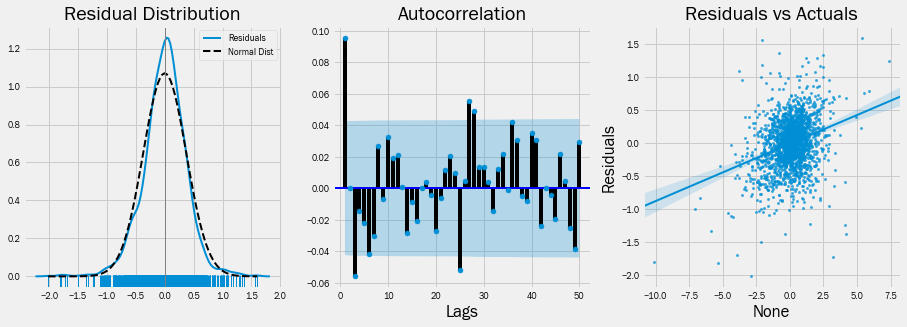

In [267]:
fig, axes = plt.subplots(ncols=3, figsize=(14,4.5))
sns.distplot(model.resid, hist=False, rug=True, ax=axes[0],
                  kde_kws={'linewidth': 2}, label='Residuals')

x = np.linspace(np.min(model.resid), np.max(model.resid), 100)
axes[0].plot(x,
        mlab.normpdf(x, np.mean(model.resid), np.std(model.resid)), 
        lw=2, ls='--', c='k', label='Normal Dist')
axes[0].axvline(0, lw=1, c='grey')
axes[0].set_title('Residual Distribution')
axes[0].legend()

plot_acf(model.resid, lags=50, zero=False, unbiased=True, ax=axes[1], lw=2)
axes[1].set_xlabel('Lags')
sns.regplot(y=model.resid.rename('Residuals'), x=endog, 
            scatter_kws={'s': 5},
            line_kws={'lw': 2},
           ax=axes[2])
axes[2].set_title('Residuals vs Actuals');